In [79]:
# imports 

import scipy.io
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split as split
import os
import pathlib
import shutil
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from timeit import default_timer as timer
import pandas as pd


# read data
path = 'data/jpg/'
batch_size = 32

mat = scipy.io.loadmat('imagelabels.mat')

labels = mat['labels'].flatten()

class_occurances = Counter(labels)


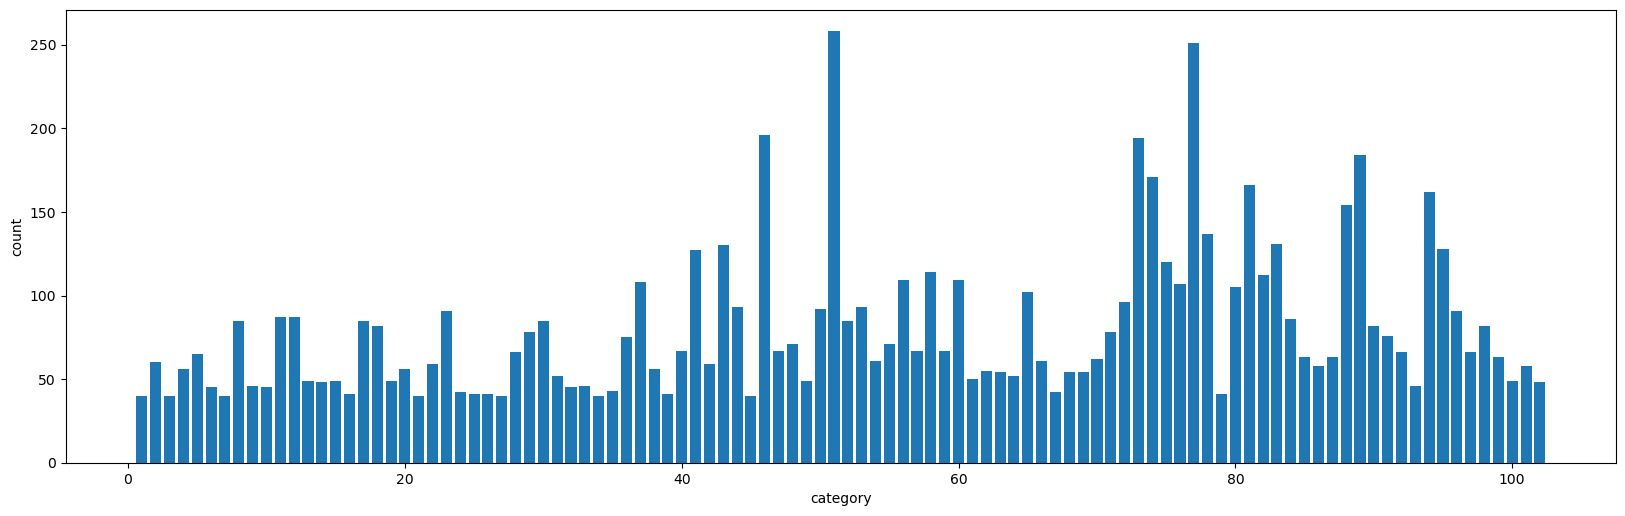

In [13]:
plt.figure(figsize=(20, 6), dpi=100)
plt.bar(class_occurances.keys(),class_occurances.values())
plt.xlabel('category')
plt.ylabel('count')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


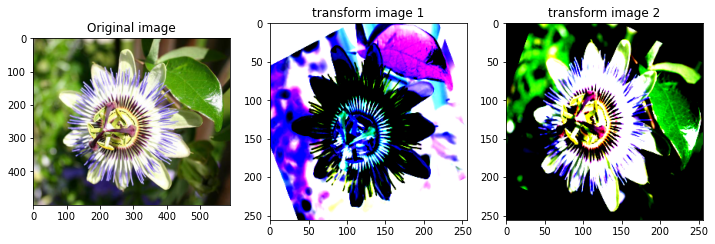

In [15]:
def print_image(original, trans1, trans2):
    fig = plt.figure(figsize=(12,8))
    plt.subplot(1,3,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.subplot(1,3,2)
    plt.title('transform image 1')
    plt.imshow(trans1.permute(1, 2, 0))
    plt.subplot(1,3,3)
    plt.title('transform image 2')
    plt.imshow(trans2.permute(1, 2, 0))
    
size = 256

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((size, size)),
                                       transforms.RandomHorizontalFlip( p =0.2),
                                       transforms.RandomInvert(p = 0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


im = Image.open(path + 'image_00001.jpg')
print_image(image, train_transforms(im), train_transforms(im))

In [ ]:
X = range(1, len(labels) + 1)

# train 0.5 test 0.25 validation 0.25
X_train1, X_test1, y_train1, y_test1 = split(X, labels, test_size=0.5)
X_test1, X_valid1, y_test1, y_valid1 = split(X_test1, y_test1, test_size=0.5)

# train 0.5 test 0.25 validation 0.25
X_train2, X_test2, y_train2, y_test2 = split(X, labels, test_size=0.5)
X_test2, X_valid2, y_test2, y_valid2 = split(X_test2, y_test2, test_size=0.5)

def category(X, Y, filename):
    if os.path.exists(filename):
         shutil.rmtree(filename)
    for i in range(1, 103):
        pathlib.Path(filename + '/' + str(i)).mkdir(parents=True, exist_ok=True)
    for x, y in zip(X, Y):
        shutil.copy(path + 'image_' + f'{x:05d}' + '.jpg', filename + '/' + str(y))

# data for iteration number 2
category(X_train1, y_train1, 'data/after/train1_0.5')
category(X_test1, y_test1, 'data/after/test1_0.25')
category(X_valid1, y_valid1, 'data/after/valid1_0.25')

# data for iteration number 2
category(X_train2, y_train2, 'data/after/train2_0.5')
category(X_test2, y_test2, 'data/after/test2_0.25')
category(X_valid2, y_valid2, 'data/after/valid2_0.25')

occ = {}
for i in range(1, 103):
    DIR = 'data/after/train1_0.5/' + str(i)
    occ[i] = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])

plt.figure(figsize=(20, 6), dpi=100)
plt.bar(occ.keys(),occ.values())
plt.xlabel('category')
plt.ylabel('count')
plt.show()

In [33]:
data_train = datasets.ImageFolder(root='data/after/train1_0.5', transform=train_transforms)
data_valid = datasets.ImageFolder(root='data/after/valid1_0.25', transform=test_transforms)
data_test = datasets.ImageFolder(root='data/after/test1_0.25', transform=test_transforms)

loader_train1 = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid1 = DataLoader(data_valid, batch_size=batch_size, shuffle=True)
loader_test1 = DataLoader(data_test, batch_size=batch_size, shuffle=True)

data_train = datasets.ImageFolder(root='data/after/train2_0.5', transform=train_transforms)
data_valid = datasets.ImageFolder(root='data/after/valid2_0.25', transform=test_transforms)
data_test = datasets.ImageFolder(root='data/after/test2_0.25', transform=test_transforms)

loader_train2 = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid2 = DataLoader(data_valid, batch_size=batch_size, shuffle=True)
loader_test2 = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [36]:
use_cuda = torch.has_cuda

if use_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')
print(device)

cpu:0


In [38]:
def model_vgg():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    n_features = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Linear(n_features, 256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256, 256), nn.ReLU(),
        nn.Linear(256, 102), nn.LogSoftmax(dim=1))
    model = model.to(device)
    return model

In [95]:
def FlowerModel():
    resnet = models.resnet18(pretrained=True).to(device)
    for param in resnet.parameters():
        param.requires_grad = False
    n_features = resnet.fc.in_features
    resnet.fc = nn.Sequential(nn.Linear(n_features, 256), nn.ReLU(), nn.Dropout(0.2), nn.Linear(256, 102), 
                             nn.LogSoftmax(dim=1))
    resnet = resnet.to(device)
    return resnet

In [97]:
def train(model, train_loader, valid_loader, learn_rate=0.001, epochs=10):
    valid_min = 10000
    log = []
    epoch_times = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    best_epoch = 0
    
    for epoch in range(epochs):
        print("starting epoch number ", epoch)
        train_loss = 0.0
        train_acc = 0
        model.train()
        start_time  = timer()
        step = 0

        # train part
        for data, label in train_loader:
            step +=1
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data.to(device))
            model.zero_grad()
            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            
            if step%20 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss: {}".format(epoch, step, len(train_loader), (train_loss/ len(train_loader.dataset))/step))

            rr, prediction = torch.max(output, dim=1)
            accuracy = torch.mean(prediction.eq(label.data.view_as(prediction)).type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            
        current_time = timer()
        train_loss = train_loss / len(train_loader.dataset)
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, epochs, train_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
        
        # eval part
        print("Starting evaluation the model")
        model.eval()
        valid_loss = 0.0
        valid_acc = 0
        
        with torch.no_grad():
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, prediction = torch.max(output, dim=1)
                correct_tensor = prediction.eq(label.data.view_as(prediction))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_acc = train_acc / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            log.append([train_loss, valid_loss, train_acc, valid_acc])

            print(f'\nFinish epoch number: {epoch} \nthe training loss is: {train_loss:.4f} \tthe validation loss is: {valid_loss:.4f}')
            print(f'\nthe training accuracy is: {100 * train_acc:.2f}%\tthe validation accuracy is: {100 * valid_acc:.2f}%')
            
            if valid_loss < valid_min:
                valid_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

    print(f'\n epoch number {best_epoch} is the best epoch, with loss of: {valid_min:.2f} and accuracy of: {100 * valid_acc:.2f}%')
    return model, log

In [98]:
def evaluate(model, test_loader):
    model.to(device)
    with torch.no_grad():
        total = 0
        acc = 0
        for x, labels in test_loader:
            x = x.to(device)
            labels = labels.to(device)
            model.to(device)
            output = model(x)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            acc += (predicted == labels).sum().item()
    print("The accuracy is: {}".format(acc/total))

In [100]:
def print_result(log):
    log = pd.DataFrame(log, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    plt.figure(figsize=(12, 8))
    for loss in ['train_loss', 'valid_loss']:
        plt.plot(log[loss], label=loss)
    plt.legend()
    plt.xlabel('Epoch number')
    plt.ylabel('Negative Log Likelihood')
    plt.title('Training and Validation Loss')
    
    plt.figure(figsize=(12, 8))
    for acc in ['train_acc', 'valid_acc']:
        plt.plot(100 * log[acc], label=acc)
    plt.legend()
    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

starting epoch number  0
Epoch 0......Step: 20/128....... Average Loss: 0.03531367567963407
Epoch 0......Step: 40/128....... Average Loss: 0.03386420542051225
Epoch 0......Step: 60/128....... Average Loss: 0.03171460723628479
Epoch 0......Step: 80/128....... Average Loss: 0.02968030716654261
Epoch 0......Step: 100/128....... Average Loss: 0.02797320641246026
Epoch 0......Step: 120/128....... Average Loss: 0.026413524944800502
Epoch 0/10 Done, Total Loss: 0.02584040658134452
Time Elapsed for Epoch: 805.3970580999994 seconds
Starting evaluation the model

Finish epoch number: 0 
the training loss is: 3.3076 	the validation loss is: 1.9424

the training accuracy is: 25.35%	the validation accuracy is: 49.95%
starting epoch number  1
Epoch 1......Step: 20/128....... Average Loss: 0.015679662636448013
Epoch 1......Step: 40/128....... Average Loss: 0.015491154372080628
Epoch 1......Step: 60/128....... Average Loss: 0.01542752600904203
Epoch 1......Step: 80/128....... Average Loss: 0.015176300

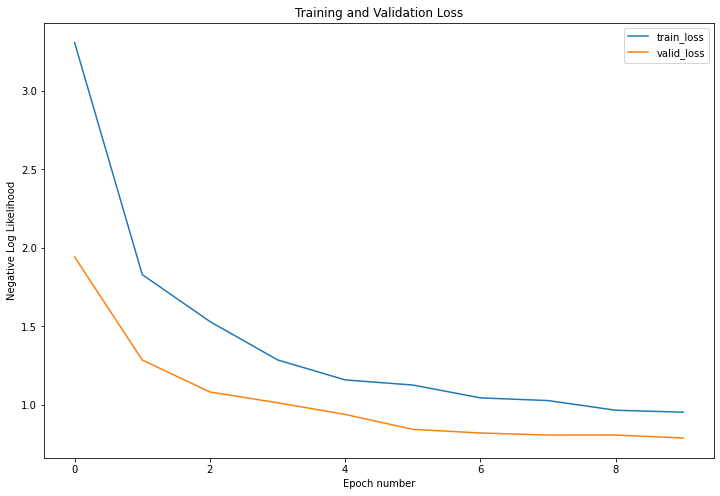

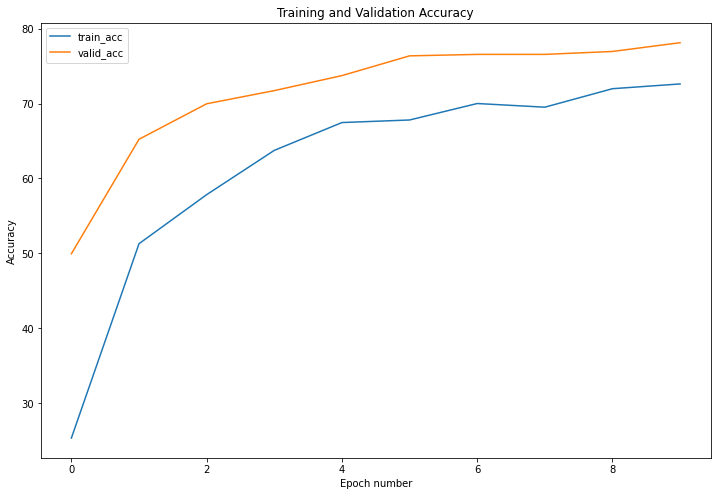

In [101]:
vgg_model = model_vgg()
model, log = train(vgg_model, loader_train1, loader_valid1)
evaluate(model, loader_test1)
print_result(log)

starting epoch number  0
Epoch 0......Step: 20/128....... Average Loss: 0.03495988552315269
Epoch 0......Step: 40/128....... Average Loss: 0.03335024414845193
Epoch 0......Step: 60/128....... Average Loss: 0.03153301025326022
Epoch 0......Step: 80/128....... Average Loss: 0.02966726724264036
Epoch 0......Step: 100/128....... Average Loss: 0.027765122950805007
Epoch 0......Step: 120/128....... Average Loss: 0.026198195044525748
Epoch 0/10 Done, Total Loss: 0.025657442063966727
Time Elapsed for Epoch: 849.2445469999948 seconds
Starting evaluation the model

Finish epoch number: 0 
the training loss is: 3.2842 	the validation loss is: 1.8848

the training accuracy is: 25.23%	the validation accuracy is: 51.71%
starting epoch number  1
Epoch 1......Step: 20/128....... Average Loss: 0.016010422233726902
Epoch 1......Step: 40/128....... Average Loss: 0.015531622169654893
Epoch 1......Step: 60/128....... Average Loss: 0.015289589714642903
Epoch 1......Step: 80/128....... Average Loss: 0.014869

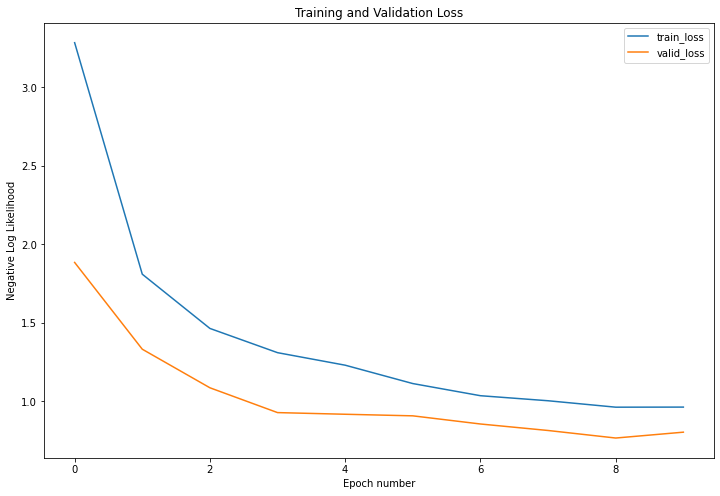

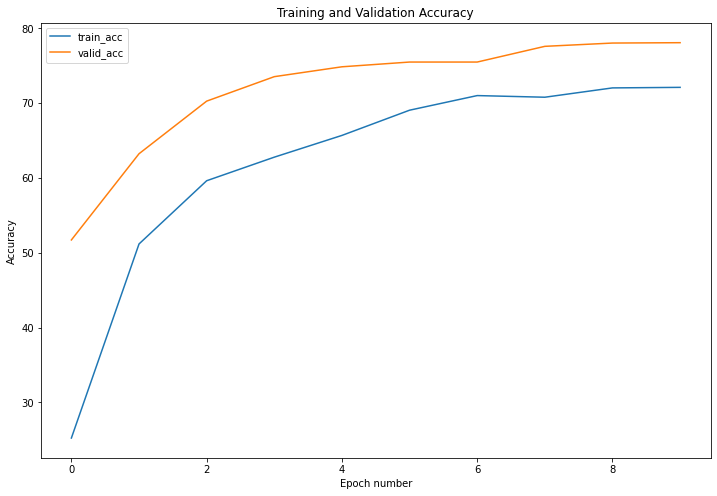

In [102]:
vgg_model = model_vgg()
model, log = train(vgg_model, loader_train2, loader_valid2)
evaluate(model, loader_test2)
print_result(log)

starting epoch number  0
Epoch 0......Step: 20/128....... Average Loss: 0.03523940685963596
Epoch 0......Step: 40/128....... Average Loss: 0.03436225710348438
Epoch 0......Step: 60/128....... Average Loss: 0.033354737474832565
Epoch 0......Step: 80/128....... Average Loss: 0.03236466779555119
Epoch 0......Step: 100/128....... Average Loss: 0.0313312275583242
Epoch 0......Step: 120/128....... Average Loss: 0.030248780072735102
Epoch 0/10 Done, Total Loss: 0.029810065341704814
Time Elapsed for Epoch: 184.43002759999945 seconds
Starting evaluation the model

Finish epoch number: 0 
the training loss is: 3.8157 	the validation loss is: 2.5754

the training accuracy is: 18.30%	the validation accuracy is: 39.79%
starting epoch number  1
Epoch 1......Step: 20/128....... Average Loss: 0.02178803356787491
Epoch 1......Step: 40/128....... Average Loss: 0.021083010751326375
Epoch 1......Step: 60/128....... Average Loss: 0.02027807760619123
Epoch 1......Step: 80/128....... Average Loss: 0.01950932

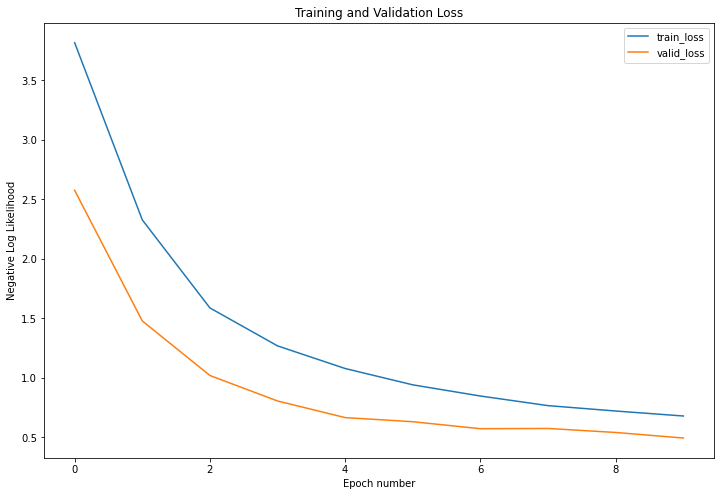

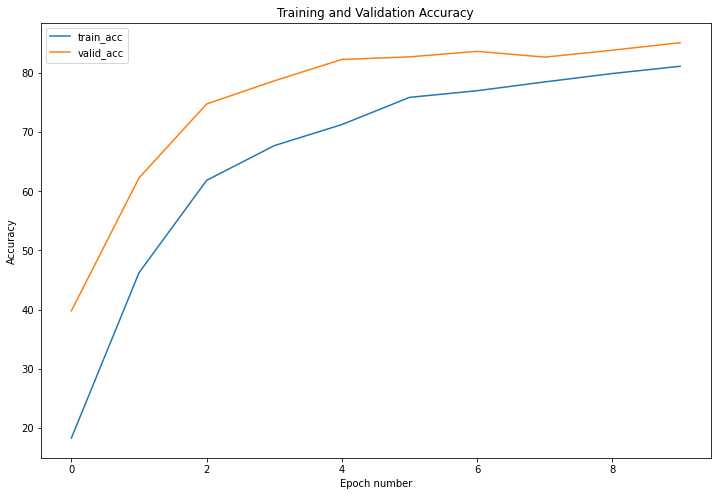

In [103]:
flower_model = FlowerModel()
model, log = train(flower_model, loader_train1, loader_valid1)
evaluate(model, loader_test1)
print_result(log)

starting epoch number  0
Epoch 0......Step: 20/128....... Average Loss: 0.03540973355843489
Epoch 0......Step: 40/128....... Average Loss: 0.034476422588011084
Epoch 0......Step: 60/128....... Average Loss: 0.033655755695739954
Epoch 0......Step: 80/128....... Average Loss: 0.03264834350880379
Epoch 0......Step: 100/128....... Average Loss: 0.031579887677124205
Epoch 0......Step: 120/128....... Average Loss: 0.030414895214682738
Epoch 0/10 Done, Total Loss: 0.029905052126749702
Time Elapsed for Epoch: 185.85106280000764 seconds
Starting evaluation the model

Finish epoch number: 0 
the training loss is: 3.8278 	the validation loss is: 2.6033

the training accuracy is: 19.08%	the validation accuracy is: 40.92%
starting epoch number  1
Epoch 1......Step: 20/128....... Average Loss: 0.021162459182925614
Epoch 1......Step: 40/128....... Average Loss: 0.02059101683370183
Epoch 1......Step: 60/128....... Average Loss: 0.02017688030646069
Epoch 1......Step: 80/128....... Average Loss: 0.01949

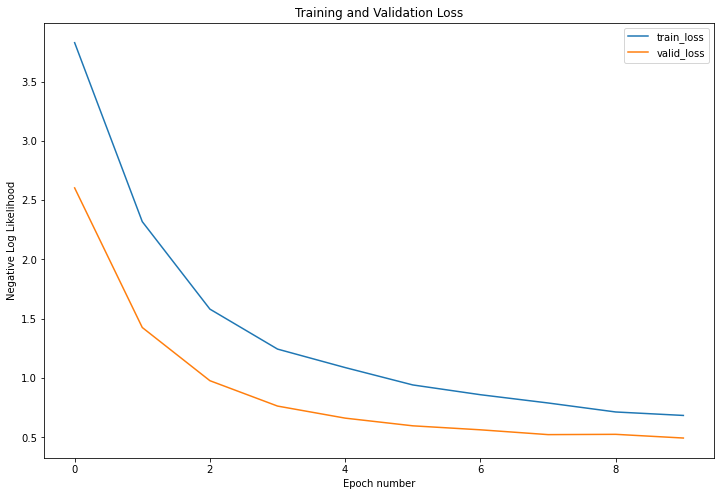

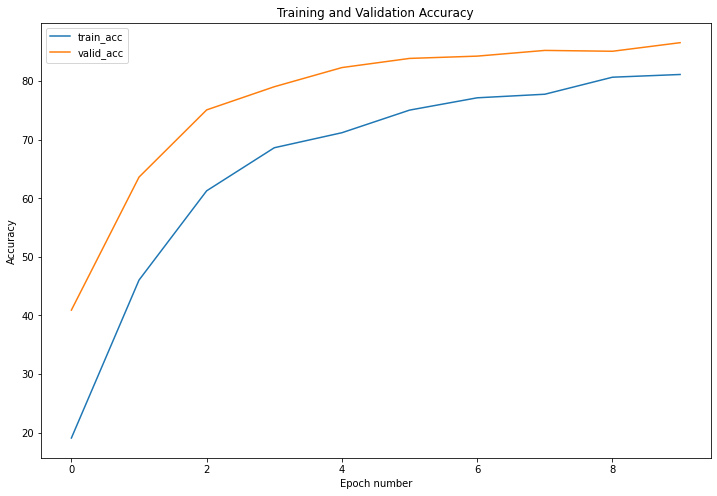

In [104]:
flower_model = FlowerModel()
model, log = train(flower_model, loader_train2, loader_valid2)
evaluate(model, loader_test2)
print_result(log)

In [105]:
flower_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [106]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1